# Applying `elo-grad` to NBA data

This notebook provides example usage of applying the `elo-grad` package to NBA data. This is based on this example notebook in the [kickscore](https://github.com/lucasmaystre/kickscore) package.

To install all the dependencies required for this notebook (and any other example notebooks), run `pip install elo-grad[examples]`.

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from elo_grad import EloEstimator, Regressor

## Getting the data

We use NBA data from [538](https://abcnews.go.com/538) under the [Creative Commons Attribution 4.0 License](https://creativecommons.org/licenses/by/4.0/).

**NOTE:** the below will not run on Windows machines. Manually download the CSV if that is the case.

In [2]:
! ! test -f ./data/nba_elo.csv && curl https://projects.fivethirtyeight.com/nba-model/nba_elo.csv -o ./data/nba_elo.csv

## Processing the data

In [3]:
df = pd.read_csv(
    './data/nba_elo.csv',
    usecols=['date', 'team1', 'team2', 'score1', 'score2', 'neutral'],
    dtype={'team1': 'category', 'team2': 'category'},
    parse_dates=['date'],
).sort_index()
# There are some duplicates here (with respect to date/team1/team2)
df = df.drop_duplicates(subset=['date', 'team1', 'team2'], keep='first').set_index('date')
df['t'] = df.index.astype(int)  # Convert to Unix timestamp
print(f'We have {df.shape[0]:,} matches.')
df.head()

We have 73,358 matches.


,neutral,team1,team2,score1,score2,t
date,,,,,,
1946-11-01,0,TRH,NYK,66,68,-731116800000000000
1946-11-02,0,PRO,BOS,59,53,-731030400000000000
1946-11-02,0,STB,PIT,56,51,-731030400000000000
1946-11-02,0,CHS,NYK,63,47,-731030400000000000
1946-11-02,0,DTF,WSC,33,50,-731030400000000000


Quick check for nulls.

In [4]:
df.isnull().sum()

neutral    0
team1      0
team2      0
score1     0
score2     0
t          0
dtype: int64

Assign a *result* field, based on the score and a *home* field.

In [5]:
df['result'] = (df['score1'] > df['score2']).astype(int)
df['home'] = np.where(df['neutral'] == 1, 0, 1).astype(bool)
df.head()

,neutral,team1,team2,score1,score2,t,result,home
date,,,,,,,,
1946-11-01,0,TRH,NYK,66,68,-731116800000000000,0,True
1946-11-02,0,PRO,BOS,59,53,-731030400000000000,1,True
1946-11-02,0,STB,PIT,56,51,-731030400000000000,1,True
1946-11-02,0,CHS,NYK,63,47,-731030400000000000,1,True
1946-11-02,0,DTF,WSC,33,50,-731030400000000000,0,True


## Train/val split

Split data into training and validation sets.
We later use the training data for setting model hyper-parameters.

In [6]:
split_date = datetime.date(2022, 1, 1)

cols = ['team1', 'team2', 'result', 't', 'home']

X_train, X_val = df.loc[:split_date, cols].set_index('t'), df.loc[split_date:, cols].set_index('t')
X_train['t'] = X_train.index
X_val['t'] = X_val.index

## Benchmark

Let's do a performance benchmark.

In [7]:
%%timeit -n 20
elo = EloEstimator(entity_cols=('team1', 'team2'), score_col='result', beta=200, k_factor=20, default_init_rating=1500)

elo.fit(X_train)

322 ms ± 5.19 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)


## Get predictions/ratings

Use the `fit` method to calculate expected scores/ratings.

In [8]:
elo = EloEstimator(
    entity_cols=('team1', 'team2'), 
    score_col='result', 
    beta=200, 
    k_factor=20, 
    default_init_rating=1500,
    track_rating_history=True,
)

preds = elo.fit(X_train)
sorted(elo.model.ratings.items(), key=lambda item: item[1][1], reverse=True)[:10]

[('NYA', (200880000000000000, 1752.0559323398625)),
 ('PHO', (1640995200000000000, 1724.2373346063296)),
 ('DNA', (200880000000000000, 1721.998076830764)),
 ('SAA', (199238400000000000, 1697.53730433188)),
 ('UTA', (1640995200000000000, 1682.0141963706546)),
 ('GSW', (1640995200000000000, 1678.9729618061392)),
 ('MIL', (1640995200000000000, 1673.7471552660552)),
 ('PHW', (-244166400000000000, 1668.484710295501)),
 ('KEN', (199584000000000000, 1657.4588446037305)),
 ('OAK', (-6825600000000000, 1656.4269126889053))]

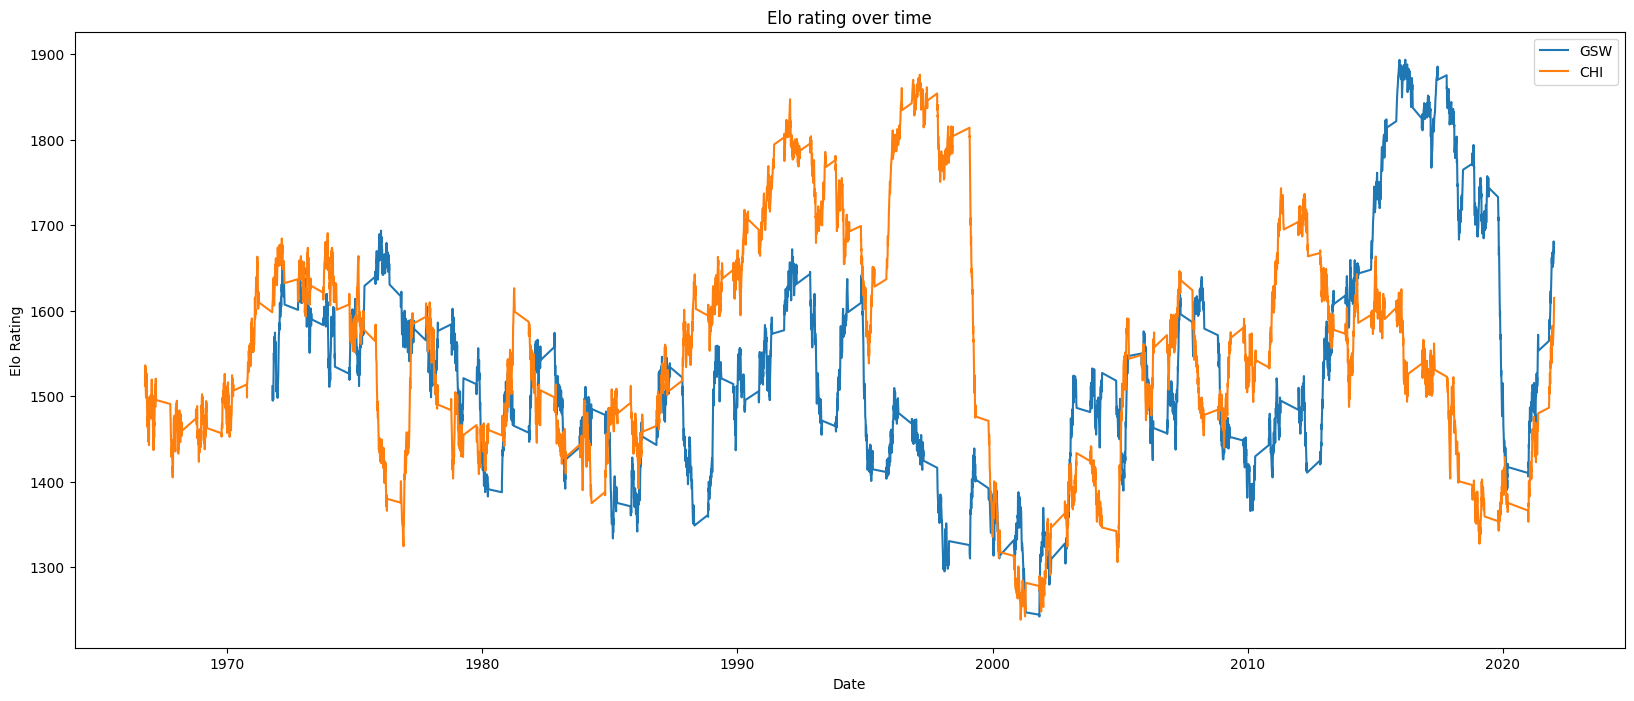

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
elo.plot(['GSW', 'CHI'], ax=ax)
plt.show()

## Evaluate the predictions

In [10]:
y_val_pred = elo.predict_proba(X_val)[:, 1]
print(f"Validation set log-loss: {log_loss(X_val['result'], y_val_pred):.4f}")

Validation set log-loss: 0.6576


Check the calibration.

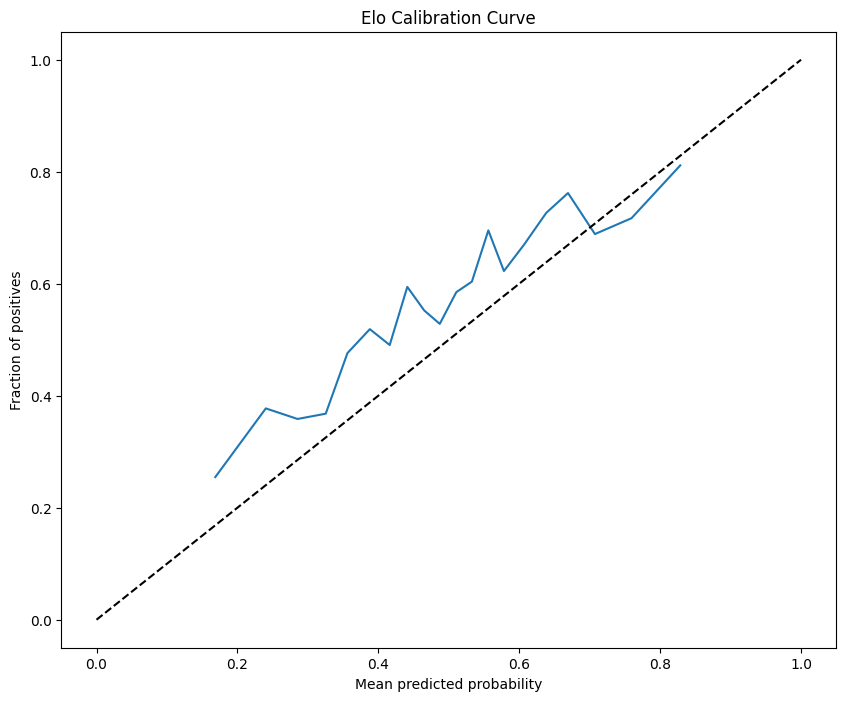

In [11]:
prob_true, prob_pred = calibration_curve(X_val['result'], y_val_pred, n_bins=20, strategy='quantile')

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(prob_pred, prob_true)
ax.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.set(
    title='Elo Calibration Curve',
    xlabel='Mean predicted probability',
    ylabel='Fraction of positives',
)

plt.show()

## Grid search

As our estimator is `scikit-learn` compatible, we can use `scikit-learn` to do things like perform a grid search over hyper-parameters.

In [12]:
gs = GridSearchCV(
    estimator=EloEstimator(entity_cols=('team1', 'team2'), score_col='result'), 
    param_grid={
        'beta': [200],
        'k_factor': [10, 100],
    },
    cv=TimeSeriesSplit(n_splits=3),
)
gs.fit(X_train, X_train['result'])
pd.DataFrame(gs.cv_results_).sort_values('mean_test_score')

/home/mike/PycharmProjects/elo-grad/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_beta,param_k_factor,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.196797,0.057767,0.090676,0.002305,200,10,"{'beta': 200, 'k_factor': 10}",0.640441,0.632651,0.636473,0.636522,0.003181,2
1,0.200570,0.095026,0.098526,0.002155,200,100,"{'beta': 200, 'k_factor': 100}",0.694953,0.676186,0.679757,0.683632,0.008137,1


## Home advantage

We can add an additional regressor to capture the effect of home advantage.
We use a smaller scale factor and set the initial rating to `0` for this additional regressor.

In [13]:
elo_home = EloEstimator(
    entity_cols=('team1', 'team2'), 
    score_col='result', 
    beta=200, 
    k_factor=20, 
    default_init_rating=1500,
    init_ratings=dict(home=(None, 0)),
    additional_regressors=[Regressor(name='home', k_factor=0.1)],
    track_rating_history=True,
)

preds = elo_home.fit(X_train)
sorted(elo_home.model.ratings.items(), key=lambda item: item[1][1], reverse=True)[:10]

[('NYA', (200880000000000000, 1757.7705885191465)),
 ('DNA', (200880000000000000, 1733.933322415204)),
 ('PHO', (1640995200000000000, 1728.2854494182488)),
 ('SAA', (199238400000000000, 1699.6982730208813)),
 ('MIL', (1640995200000000000, 1684.4847322369192)),
 ('PHW', (-244166400000000000, 1682.22638332175)),
 ('GSW', (1640995200000000000, 1680.7636220953675)),
 ('UTA', (1640995200000000000, 1679.1767276778162)),
 ('KEN', (199584000000000000, 1661.6358674201638)),
 ('OAK', (-6825600000000000, 1655.0264875334096))]

We see that adding this regressor reduces the log-loss.

In [14]:
y_val_pred_home = elo_home.predict_proba(X_val)[:, 1]
print(f"Validation set log-loss: {log_loss(X_val['result'], y_val_pred_home):.4f}")

Validation set log-loss: 0.6470


We can also visualise the home advantage effect over time.

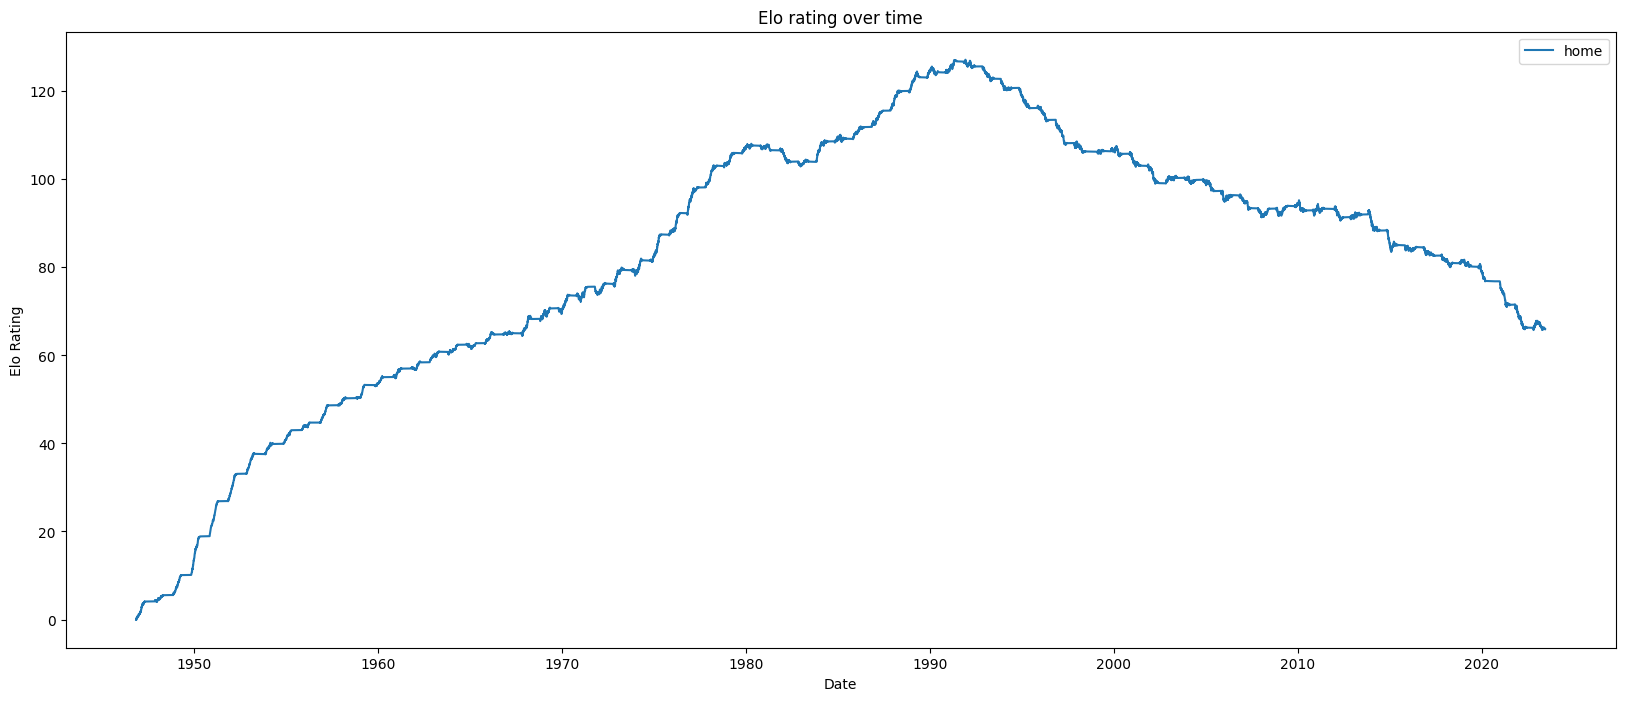

In [15]:
fig, ax = plt.subplots(figsize=(20, 8))
elo_home.plot(['home'], ax=ax)
plt.show()

Let's benchmark performance when we add in home advantage.

In [16]:
%%timeit -n 20
elo_home = EloEstimator(
    entity_cols=('team1', 'team2'), 
    score_col='result', 
    beta=200, 
    k_factor=20, 
    default_init_rating=1500,
    init_ratings=dict(home=(None, 0)),
    additional_regressors=[Regressor(name='home', k_factor=0.1)],
)

elo_home.fit(X_train)

631 ms ± 44.2 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)


### Regularisation

We can also apply regularisation to the home weights.

In [17]:
elo_home_reg = EloEstimator(
    entity_cols=('team1', 'team2'), 
    score_col='result', 
    beta=200, 
    k_factor=20, 
    default_init_rating=1500,
    init_ratings=dict(home=(None, 0)),
    additional_regressors=[Regressor(name='home', k_factor=0.1, penalty='l2', lambda_reg=1e-4)],
    track_rating_history=True,
)

preds = elo_home_reg.fit(X_train)
sorted(elo_home_reg.model.ratings.items(), key=lambda item: item[1][1], reverse=True)[:10]

[('NYA', (200880000000000000, 1756.364794538363)),
 ('DNA', (200880000000000000, 1731.6268211539327)),
 ('PHO', (1640995200000000000, 1726.6241422188377)),
 ('SAA', (199238400000000000, 1698.853693740763)),
 ('MIL', (1640995200000000000, 1681.7342369336159)),
 ('PHW', (-244166400000000000, 1681.5071518721766)),
 ('GSW', (1640995200000000000, 1680.100329968933)),
 ('UTA', (1640995200000000000, 1678.8131092461506)),
 ('KEN', (199584000000000000, 1660.607732373534)),
 ('OAK', (-6825600000000000, 1654.9329828731652))]

We see that adding this regressor reduces the log-loss.

In [18]:
y_val_pred_home_reg = elo_home_reg.predict_proba(X_val)[:, 1]
print(f"Validation set log-loss: {log_loss(X_val['result'], y_val_pred_home_reg):.4f}")

Validation set log-loss: 0.6463


and changes the ratings:

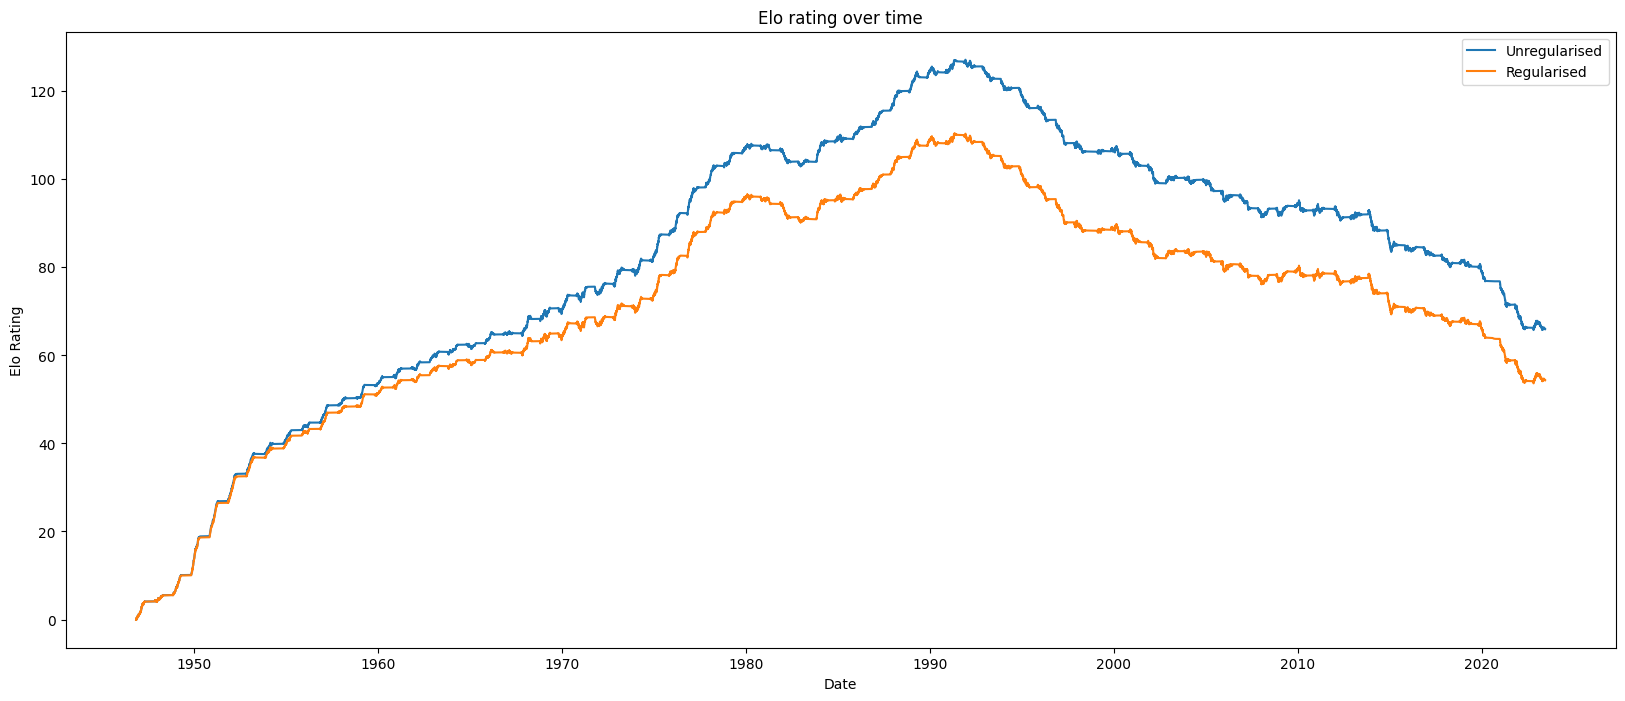

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
elo_home.plot(['home'], ax=ax, labels=['Unregularised'])
elo_home_reg.plot(['home'], ax=ax, labels=['Regularised'])
plt.show()